<a href="https://colab.research.google.com/github/otavioaugusto1/Deep-Learning-with-PyTorch/blob/main/Deep_learning_com_pytorch_datasets_e_fluxo_de_valida%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Carregamento de Dados**
Objetivos dessa aula:

**Carregar um dataset customizado**
Implementar o fluxo de treinamento e validação completo de uma rede
Hiperparâmetros
Vamos manter a organização do último script :)

**imports de pacotes**
configuração de hiperparâmetros
definição do hardware padrão utilizado
E bora de GPU de novo!

In [1]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import time
import os


import matplotlib.pyplot as plt
%matplotlib inline

# Configurando hiperparâmetros.
args = {
    'epoch_num': 200,     # Número de épocas.
    'lr': 5e-5,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L2 (Regularização).
    'num_workers': 3,     # Número de threads do dataloader.
    'batch_size': 20,     # Tamanho do batch.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


**Dataset**
Dataset de aplicativos para aluguel de bicicletas (Bike Sharing Dataset).

Dadas algumas informações como velocidade do vento, estação do ano, etc., quantas bicicletas serão alugadas na próxima hora?

Esse é um problema de Regressão, onde precisamos estimar uma variável dependente em um espaço contínuo (alugueis de bikes) a partir de um conjunto de variáveis independentes (as condições no momento).

**Baixando o dataset**
Fonte: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [2]:

! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
! unzip Bike-Sharing-Dataset.zip

--2021-05-13 01:07:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279992 (273K) [application/x-httpd-php]
Saving to: ‘Bike-Sharing-Dataset.zip’

Bike-Sharing-Datase 100%[===================>] 273.43K   855KB/s    in 0.3s    

2021-05-13 01:07:21 (855 KB/s) - ‘Bike-Sharing-Dataset.zip’ saved [279992/279992]

Archive:  Bike-Sharing-Dataset.zip
  inflating: Readme.txt              
  inflating: day.csv                 
  inflating: hour.csv                


Visualizando os dados


In [3]:

df = pd.read_csv('hour.csv')
print(len(df))
df.head()


17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


**Tratamento de dados**

**Variáveis Categóricas**

Como descrito na página do dataset, apenas as variáveis numéricas estão normalizadas. No caso das categóricas (como dia da semana e estação do ano), cada elemento contém o índice da categoria.

Existem várias formas de lidar com variáveis categóricas em uma regressão, mas para não desviar o foco da nossa aula manteremos os valores originais das variáveis categóricas.

**Separação em treino e teste**

Para treinar e validar o nosso modelo, precisamos de dois conjuntos de dados (treino e teste). Para isso, utilizaremos a função torch.randperm para amostrar aleatoriamente um percentual dos dados, separando-os para validação.

Documentação: https://pytorch.org/docs/stable/torch.html#torch.randperm

In [4]:
# Train/Test split
torch.manual_seed(1)
indices = torch.randperm(len(df)).tolist()

train_size = int(0.8*len(df))
df_train = df.iloc[indices[:train_size]]
df_test  = df.iloc[indices[train_size:]]

print(len(df_train), len(df_test))
display(df_test.head())

df_train.to_csv('bike_train.csv',index=False)
df_test.to_csv('bike_test.csv',index=False)
!ls

13903 3476


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12663,12664,2012-06-16,2,1,6,20,0,6,0,2,0.66,0.6212,0.47,0.1940,123,229,352
1801,1802,2011-03-20,1,0,3,18,0,0,0,1,0.38,0.3939,0.40,0.3582,58,98,156
16567,16568,2012-11-28,4,1,11,1,0,3,1,2,0.26,0.2576,0.75,0.2239,0,12,12
8817,8818,2012-01-08,1,1,1,5,0,0,0,2,0.32,0.3333,0.49,0.1045,0,2,2
2608,2609,2011-04-23,2,0,4,14,0,6,0,1,0.58,0.5455,0.78,0.3582,182,209,391


Bike-Sharing-Dataset.zip  bike_train.csv  hour.csv    sample_data
bike_test.csv		  day.csv	  Readme.txt


**Classe Dataset**

O pacote torch.util.data possui a classe abstrata Dataset. Ela permite que você implemente o seu próprio dataset reescrevendo os métodos:

    __init__(self): Define a lista de amostras do seu dataset
    __getitem__(self, idx): Carrega uma amostra, aplica as devidas transformações e retorna uma tupla (dado, rótulo).
    __len__(self): Retorna a quantidade de amostras do dataset

Tutorial completo do PyTorch: 

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
class Bicicletinha(Dataset):
  def __init__(self, csv_path, scaler_feat=None, scaler_label=None):
  
    self.dados = pd.read_csv(csv_path).to_numpy()
    
  def __getitem__(self, idx):
    
    sample = self.dados[idx][2:14]
    label  = self.dados[idx][-1:]
    
    # converte para tensor
    sample = torch.from_numpy(sample.astype(np.float32))
    label  = torch.from_numpy(label.astype(np.float32))
    
    return sample, label
    
  def __len__(self):
    return len(self.dados)

In [6]:
dataset = Bicicletinha('bike_train.csv')
dado, rotulo = dataset[0]
print(rotulo)
print(dado)

tensor([373.])
tensor([ 4.0000,  1.0000, 11.0000, 19.0000,  0.0000,  4.0000,  1.0000,  1.0000,
         0.3800,  0.3939,  0.2700,  0.3582])


**Construindo conjuntos de treino e teste**

In [7]:
train_set = Bicicletinha('bike_train.csv')
test_set  = Bicicletinha('bike_test.csv')

print('Tamanho do treino: ' + str(len(train_set)) + ' amostras')
print('Tamanho do teste: ' + str(len(test_set)) + ' amostras')

Tamanho do treino: 13903 amostras
Tamanho do teste: 3476 amostras



Dataloader

In [8]:
# Criando dataloader
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


O objeto retornado é um iterador, podendo ser utilizado para iterar em loops mas não suportando indexação.

In [9]:
for batch in test_loader:
  
  dado, rotulo = batch
  print('## Dimensionalidade do batch ##')
  print(dado.size(), rotulo.size())
  
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Dimensionalidade do batch ##
torch.Size([20, 12]) torch.Size([20, 1])


**Implementando o MLP**
Essa parte aqui você já tira de letra! Minha sugestão é construir um modelo com:

Duas camadas escondidas. Lembre-se de alternar as camadas com ativações não-lineares.
Uma camada de saída (com qual ativação?)

In [10]:
class MLP(nn.Module):
  
  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()
    
    self.features = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, out_size),
        nn.ReLU(),
    )

  def forward(self, X):
    
    hidden = self.features(X)
    output = self.classifier(hidden)
    
    return output

input_size  = train_set[0][0].size(0)
hidden_size = 128
out_size    = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])
print(net)

MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): ReLU()
  )
)


**Definindo loss e otimizador**

Se lembra quais as funções de perda adequadas para um problema de regressão?

In [11]:
criterion = nn.L1Loss().to(args['device'])

optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

## **Fluxo de Treinamento & Validação**
Treinamento
Relembrando o passo a passo do fluxo de treinamento:

Iterar nas épocas

Iterar nos batches

Cast dos dados no dispositivo de hardware

Forward na rede e cálculo da loss

Cálculo do gradiente e atualização dos pesos

Esse conjunto de passos é responsável pelo processo iterativo de otimização de uma rede. A validação por outro lado, é apenas a aplicação da rede em dados nunca antes visto para estimar a qualidade do modelo no mundo real.

Validação

Para essa etapa, o PyTorch oferece dois artifícios:

model.eval(): Impacta no forward da rede, informando as camadas caso seu comportamento mude entre fluxos (ex: dropout).
with torch.no_grad(): Gerenciador de contexto que desabilita o cálculo e armazenamento de gradientes (economia de tempo e memória). Todo o código de validação deve ser executado dentro desse contexto.
Exemplo de código para validação

    net.eval()
    with torch.no_grad():
      for batch in test_loader:
          # Código de validação
    Existe o equivalente ao model.eval() para explicitar que a sua rede deve estar em modo de treino, é o model.train(). Apesar de ser o padrão dos modelos, é boa prática definir também o modo de treinamento.

In [12]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()
  
  start = time.time()
  
  epoch_loss  = []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  
  end = time.time()
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()

In [13]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

  epoch_loss = np.asarray(epoch_loss)
  
  end = time.time()
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Time: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))
  
  return epoch_loss.mean()


In [14]:
train_losses, test_losses = [], []
for epoch in range(args['epoch_num']):
  
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#################### Train ####################
Epoch 0, Loss: 164.3091 +/- 41.8290, Time: 2.75
********** Validate **********
Epoch 0, Loss: 126.1877 +/- 30.5127, Time: 0.45

#################### Train ####################
Epoch 1, Loss: 132.0851 +/- 25.0518, Time: 2.54
********** Validate **********
Epoch 1, Loss: 127.3917 +/- 24.2552, Time: 0.48

#################### Train ####################
Epoch 2, Loss: 123.5236 +/- 29.5951, Time: 2.57
********** Validate **********
Epoch 2, Loss: 127.1817 +/- 31.9073, Time: 0.47

#################### Train ####################
Epoch 3, Loss: 122.3897 +/- 31.0318, Time: 2.62
********** Validate **********
Epoch 3, Loss: 116.1245 +/- 26.5783, Time: 0.48

#################### Train ####################
Epoch 4, Loss: 120.4208 +/- 26.0317, Time: 2.87
********** Validate **********
Epoch 4, Loss: 115.0319 +/- 27.3075, Time: 0.50

#################### Train ####################
Epoch 5, Loss: 119.6440 +/- 29.9864, Time: 2.85
********** Validate ****

In [15]:
Xtest = torch.stack([tup[0] for tup in test_set])
Xtest = Xtest.to(args['device'])

ytest = torch.stack([tup[1] for tup in test_set])
ypred = net(Xtest).cpu().data

data = torch.cat((ytest, ypred), axis=1)

df_results = pd.DataFrame(data, columns=['ypred', 'ytest'])
df_results.head(20)

,ypred,ytest
0,tensor(352.),tensor(258.5137)
1,tensor(156.),tensor(116.8862)
2,tensor(12.),tensor(9.5872)
3,tensor(2.),tensor(0.)
4,tensor(391.),tensor(307.9059)
5,tensor(391.),tensor(301.5105)
6,tensor(84.),tensor(169.5561)
7,tensor(487.),tensor(609.4336)
8,tensor(176.),tensor(184.1704)
9,tensor(157.),tensor(71.7680)


Gráfico de convergência

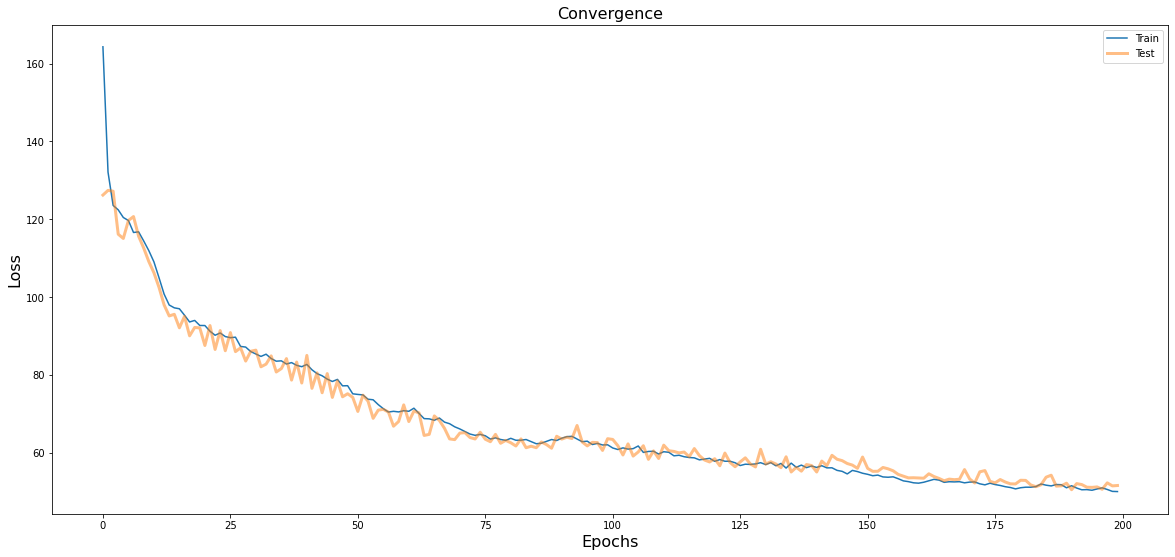

In [16]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()